In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, classification_report


In [2]:

def print_avg_and_mean(dict):
    # Ponderado
    weighted_avg_precision = dict['weighted avg']['precision']
    weighted_avg_recall = dict['weighted avg']['recall']
    weighted_avg_f1_score = dict['weighted avg']['f1-score']
    weighted_avg_support = dict['weighted avg']['support']

    # Aritmético
    mean_precision = np.mean([dict[label]["precision"] for label in dict.keys() if label != "accuracy"])
    mean_recall = np.mean([dict[label]["recall"] for label in dict.keys() if label != "accuracy"])
    mean_f1_score = np.mean([dict[label]["f1-score"] for label in dict.keys() if label != "accuracy"])
    mean_support = np.mean([dict[label]["support"] for label in dict.keys() if label != "accuracy"])

    print(f'Média Ponderada - Precisão: {weighted_avg_precision}')
    print(f'Média Ponderada - Recall: {weighted_avg_recall}')
    print(f'Média Ponderada - F1-Score: {weighted_avg_f1_score}')
    print(f'Média Ponderada - Support: {weighted_avg_support}')
    print('--------------------------------------------------')
    print(f'Média Aritmética - Precisão: {mean_precision}')
    print(f'Média Aritmética - Recall: {mean_recall}')
    print(f'Média Aritmética - F1-Score: {mean_f1_score}')
    print(f'Média Aritmética - Support: {mean_support}')


In [3]:

# Definindo o valor das seeds para garantir reprodutibilidade
RANDOM_SEED = 42
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Carregar os dados de treino e teste
mitbih_train = pd.read_csv('mitbih_test.csv', header=None)
mitbih_test = pd.read_csv('mitbih_train.csv', header=None)

# Separar os conjuntos de treino e teste 
x_train = mitbih_train.iloc[:, :-1].values
y_train = mitbih_train.iloc[:, -1].values

# Variáveis para teste e validação (50% teste - 50% validação)
X_test, X_val, y_test, y_val = train_test_split(
    mitbih_test.iloc[:, :-1].values, 
    mitbih_test.iloc[:, -1].values, 
    test_size=0.5, 
    random_state=RANDOM_SEED
)


In [4]:
#Criar o pipeline para padronização e treinamento do modelo MLP
MLP = make_pipeline(StandardScaler(), MLPClassifier(random_state=RANDOM_SEED))
# Treinamento do modelo
MLP.fit(x_train, y_train)

# Previsão com base no conjunto de validação
y_val_pred = MLP.predict(X_val)
classification_report_val = classification_report(y_val, y_val_pred)

y_test_pred = MLP.predict(X_test)
classification_report_test = classification_report(y_test, y_test_pred)

print("Relatório de Classificação - Validação (KNN)")
print(classification_report(y_val, y_val_pred))

print("Relatório de Classificação - Teste (KNN)")
print(classification_report(y_test, y_test_pred))

cm_test = confusion_matrix(y_test, y_test_pred)
specificities_test = []
for i in range(len(cm_test)):
    TN = np.sum(cm_test) - np.sum(cm_test[i, :]) - np.sum(cm_test[:, i]) + cm_test[i, i]
    FP = np.sum(cm_test[:, i]) - cm_test[i, i]
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    specificities_test.append(specificity)

specificity_mean_test = np.mean(specificities_test)
print(f"Especificidade Média do MLP (Teste): {specificity_mean_test:.4f}")

cm_val = confusion_matrix(y_val, y_val_pred)
specificities_val = []
for i in range(len(cm_val)):
    TN = np.sum(cm_val) - np.sum(cm_val[i, :]) - np.sum(cm_val[:, i]) + cm_val[i, i]
    FP = np.sum(cm_val[:, i]) - cm_val[i, i]
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    specificities_val.append(specificity)

specificity_mean_val = np.mean(specificities_val)
print(f"Especificidade Média do MLP (Validação): {specificity_mean_val:.4f}")

Relatório de Classificação - Validação (KNN)
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98     36284
         1.0       0.77      0.67      0.72      1066
         2.0       0.90      0.90      0.90      2876
         3.0       0.79      0.48      0.60       324
         4.0       0.97      0.97      0.97      3227

    accuracy                           0.97     43777
   macro avg       0.88      0.80      0.84     43777
weighted avg       0.97      0.97      0.97     43777

Relatório de Classificação - Teste (KNN)
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98     36187
         1.0       0.76      0.68      0.72      1157
         2.0       0.90      0.90      0.90      2912
         3.0       0.80      0.49      0.61       317
         4.0       0.97      0.96      0.96      3204

    accuracy                           0.97     43777
   macro avg       0.88      0.80      0.84  

[[35693   222   182    21    69]
 [  346   787    17     0     7]
 [  226    19  2619    17    31]
 [   96     0    63   156     2]
 [   91     2    25     0  3086]]


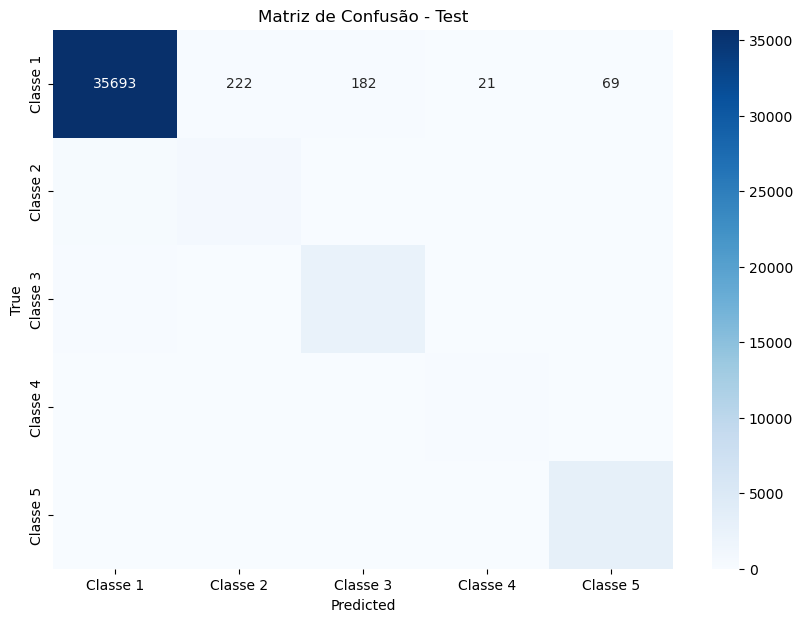

In [5]:
print(cm_test)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_test, annot=True, fmt='g', cmap='Blues', xticklabels=['Classe 1', 'Classe 2', 'Classe 3', 'Classe 4', 'Classe 5'], yticklabels=['Classe 1', 'Classe 2', 'Classe 3', 'Classe 4', 'Classe 5'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Matriz de Confusão - Test')
plt.show()

[[35833   189   176    27    59]
 [  319   718    26     0     3]
 [  228    20  2589    14    25]
 [   99     1    67   157     0]
 [   68     2    23     0  3134]]


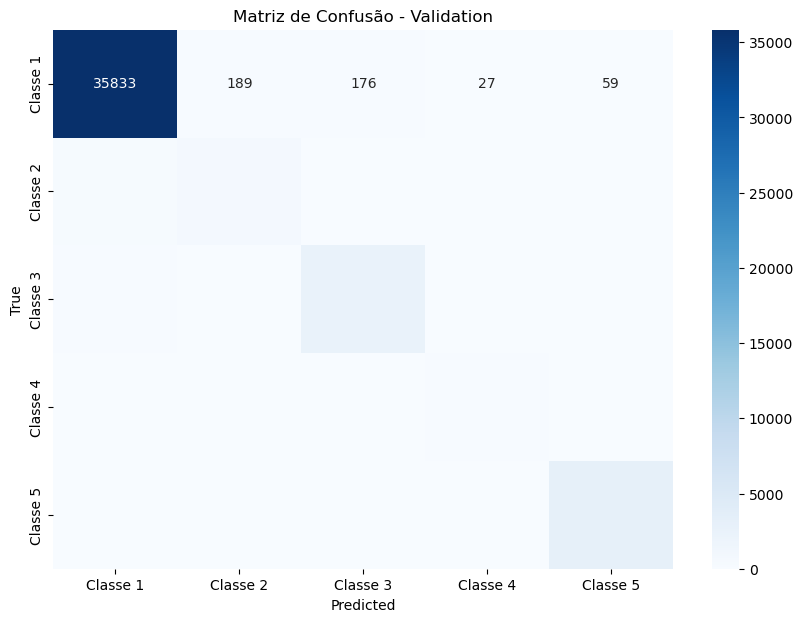

In [6]:
print(cm_val)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_val, annot=True, fmt='g', cmap='Blues', xticklabels=['Classe 1', 'Classe 2', 'Classe 3', 'Classe 4', 'Classe 5'], yticklabels=['Classe 1', 'Classe 2', 'Classe 3', 'Classe 4', 'Classe 5'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Matriz de Confusão - Validation')
plt.show()

In [7]:
#Criar o pipeline para padronização e treinamento do modelo MLP
MLP_Best = make_pipeline(StandardScaler(), MLPClassifier(activation = 'tanh', alpha = 0.0001,
                                                    hidden_layer_sizes =(150,), 
                                                    learning_rate = 'constant', 
                                                    solver = 'adam', random_state=RANDOM_SEED))
# Treinamento do modelo
MLP_Best.fit(x_train, y_train)

# Previsão com base no conjunto de validação
y_val_pred = MLP_Best.predict(X_val)
classification_report_val = classification_report(y_val, y_val_pred)

y_test_pred = MLP_Best.predict(X_test)
classification_report_test = classification_report(y_test, y_test_pred)

print("Relatório de Classificação - Validação (KNN)")
print(classification_report(y_val, y_val_pred))

print("Relatório de Classificação - Teste (KNN)")
print(classification_report(y_test, y_test_pred))

cm_test = confusion_matrix(y_test, y_test_pred)
specificities_test = []
for i in range(len(cm_test)):
    TN = np.sum(cm_test) - np.sum(cm_test[i, :]) - np.sum(cm_test[:, i]) + cm_test[i, i]
    FP = np.sum(cm_test[:, i]) - cm_test[i, i]
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    specificities_test.append(specificity)

specificity_mean_test = np.mean(specificities_test)
print(f"Especificidade Média do MLP (Teste): {specificity_mean_test:.4f}")

cm_val = confusion_matrix(y_val, y_val_pred)
specificities_val = []
for i in range(len(cm_val)):
    TN = np.sum(cm_val) - np.sum(cm_val[i, :]) - np.sum(cm_val[:, i]) + cm_val[i, i]
    FP = np.sum(cm_val[:, i]) - cm_val[i, i]
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    specificities_val.append(specificity)

specificity_mean_val = np.mean(specificities_val)
print(f"Especificidade Média do MLP (Validação): {specificity_mean_val:.4f}")

Relatório de Classificação - Validação (KNN)
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99     36284
         1.0       0.85      0.67      0.75      1066
         2.0       0.91      0.90      0.90      2876
         3.0       0.80      0.60      0.69       324
         4.0       0.97      0.96      0.97      3227

    accuracy                           0.97     43777
   macro avg       0.90      0.82      0.86     43777
weighted avg       0.97      0.97      0.97     43777

Relatório de Classificação - Teste (KNN)
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98     36187
         1.0       0.83      0.68      0.74      1157
         2.0       0.91      0.92      0.91      2912
         3.0       0.83      0.60      0.69       317
         4.0       0.98      0.96      0.97      3204

    accuracy                           0.97     43777
   macro avg       0.90      0.83      0.86  

[[35787   154   182    21    43]
 [  341   784    23     2     7]
 [  197     7  2668    15    25]
 [   83     1    43   189     1]
 [  103     2    13     1  3085]]


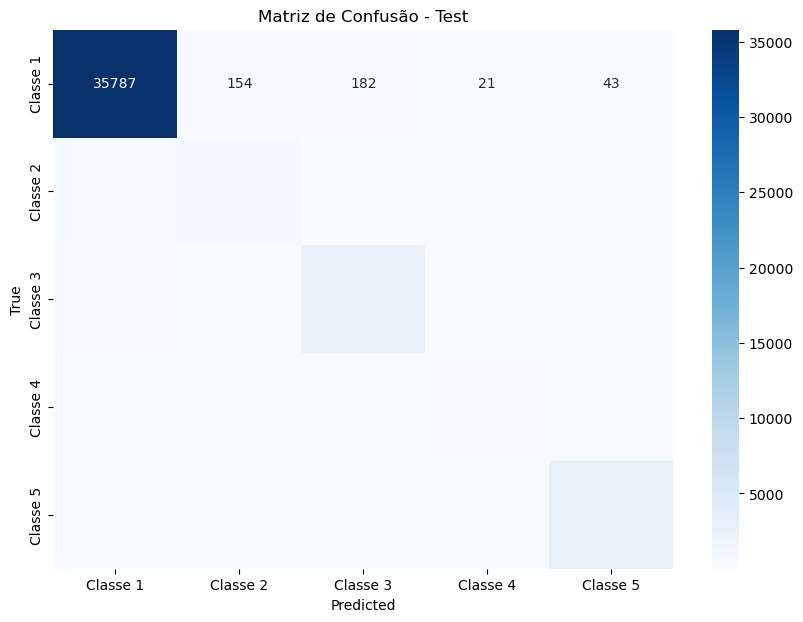

In [8]:
print(cm_test)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_test, annot=True, fmt='g', cmap='Blues', xticklabels=['Classe 1', 'Classe 2', 'Classe 3', 'Classe 4', 'Classe 5'], yticklabels=['Classe 1', 'Classe 2', 'Classe 3', 'Classe 4', 'Classe 5'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Matriz de Confusão - Test')
plt.show()

[[35946   114   151    30    43]
 [  316   719    24     1     6]
 [  236    12  2577    16    35]
 [   75     2    53   194     0]
 [   84     3    28     0  3112]]


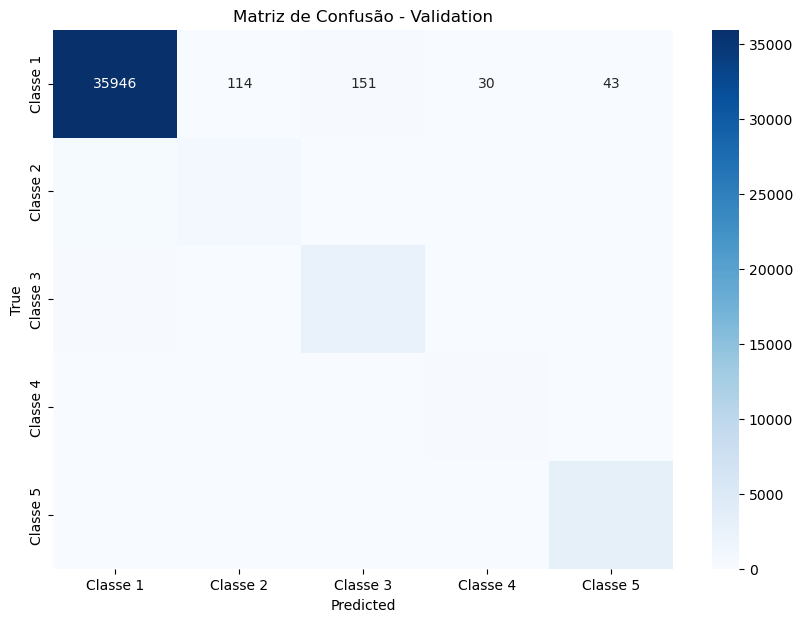

In [9]:
print(cm_val)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_val, annot=True, fmt='g', cmap='Blues', xticklabels=['Classe 1', 'Classe 2', 'Classe 3', 'Classe 4', 'Classe 5'], yticklabels=['Classe 1', 'Classe 2', 'Classe 3', 'Classe 4', 'Classe 5'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Matriz de Confusão - Validation')
plt.show()